In [34]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import keras

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['hover-data', 'touch-data']

# image size
IMG_SIZE = 48
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

## helper function to pre-process images (color channel conversion and resizing)

## load images and annotations

In [16]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists

for filename in tqdm(os.listdir('hover-data-border')): # hover = 0
    # extract unique ID from file name
    #UID = filename.split('.')[0]
    img = cv2.imread(f'hover-data-border/{filename}')

    rzd = cv2.resize(img, SIZE)
    # iterate over all hands annotated in the image
    # get the annotated hand's label
    # if we have not seen this label yet, add it to the list of labels
    #label = annotation['labels'][i]

    images.append(rzd)
    labels.append(0)

for filename in tqdm(os.listdir('touch-data-border')): # hover = 0
    # extract unique ID from file name
    #UID = filename.split('.')[0]
    img = cv2.imread(f'touch-data-border/{filename}')

    # iterate over all hands annotated in the image
    # get the annotated hand's label
    # if we have not seen this label yet, add it to the list of labels
    #label = annotation['labels'][i]
    
    rzd = cv2.resize(img, SIZE)

    images.append(rzd)
    labels.append(1)

  0%|          | 0/4156 [00:00<?, ?it/s]

  0%|          | 0/3627 [00:00<?, ?it/s]

## let's have a look at one of the images

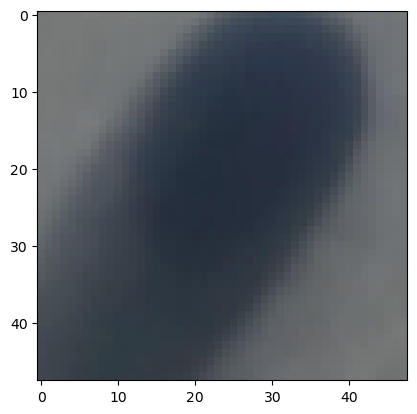

In [17]:
#plt.imshow(random.sample(images, 1)[0])
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

7004
779
7004
779


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [19]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

# wir bekommen am Ende riesengroßes Array -> so ID, dann blabla 
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(7004, 48, 48, 3) (779, 48, 48, 3) (7004, 2) (779, 2)


In [20]:
# variables for hyperparameters
batch_size = 8
epochs = 7
num_classes = len(set(labels))
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
#model.add(RandomFlip('horizontal'))
#model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
# 20% Neuronen werden random einfach ausgeschaltet / auf 0 gesetzt
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## now, we can train the model using the fit() function
## this will take a while

In [21]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/7
876/876 [==============================] - 19s 20ms/step - loss: 0.1932 - accuracy: 0.9129 - val_loss: 0.0427 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 2/7
876/876 [==============================] - 19s 22ms/step - loss: 0.0919 - accuracy: 0.9684 - val_loss: 0.0651 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 3/7
876/876 [==============================] - 19s 22ms/step - loss: 0.0764 - accuracy: 0.9720 - val_loss: 0.0294 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 4/7
876/876 [==============================] - 19s 22ms/step - loss: 0.0673 - accuracy: 0.9739 - val_loss: 0.0410 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 5/7
876/876 [==============================] - 19s 22ms/step - loss: 0.0685 - accuracy: 0.9762 - val_loss: 0.0314 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 6/7
876/876 [==============================] - 21s 23ms/step - loss: 0.0406 - accuracy: 0.9850 - val_loss: 0.0417 - val_accuracy: 0.9820 - lr: 2.0000e-04


In [22]:
# let's have a look at our model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 48, 48, 3)        0         
 tation)                                                         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        15616     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 32)        51232     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                      

## Plot accuracy and loss of the training process

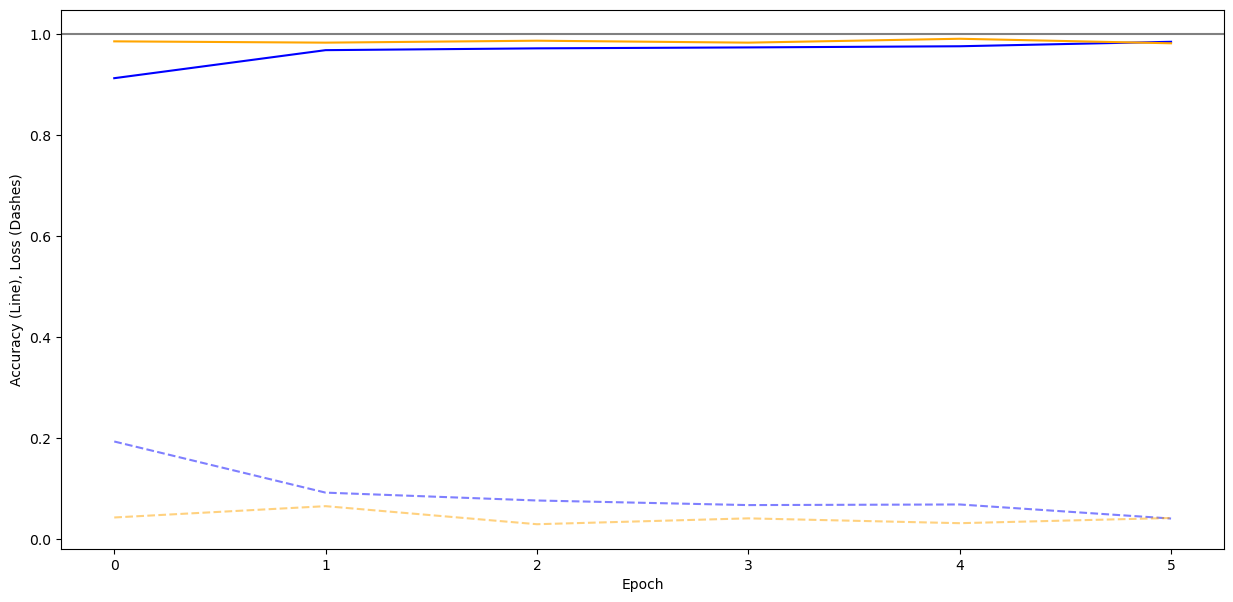

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [24]:
model.save('touch-recognizer-64_border_test_e6')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

INFO:tensorflow:Assets written to: touch-recognizer-64_border_test_e6\assets


INFO:tensorflow:Assets written to: touch-recognizer-64_border_test_e6\assets


## visualize classification results with a confusion matrix

25/25 [==============================] - 0s 15ms/step
before [[9.9999988e-01 9.3131355e-08]
 [9.9999988e-01 7.5465117e-08]
 [9.9999452e-01 5.4907509e-06]
 ...
 [3.6034098e-09 1.0000000e+00]
 [9.9682498e-01 3.1749834e-03]
 [9.9900383e-01 9.9618151e-04]]
probabilities [0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0
 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1
 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 0
 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1
 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0
 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1
 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1
 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0
 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1

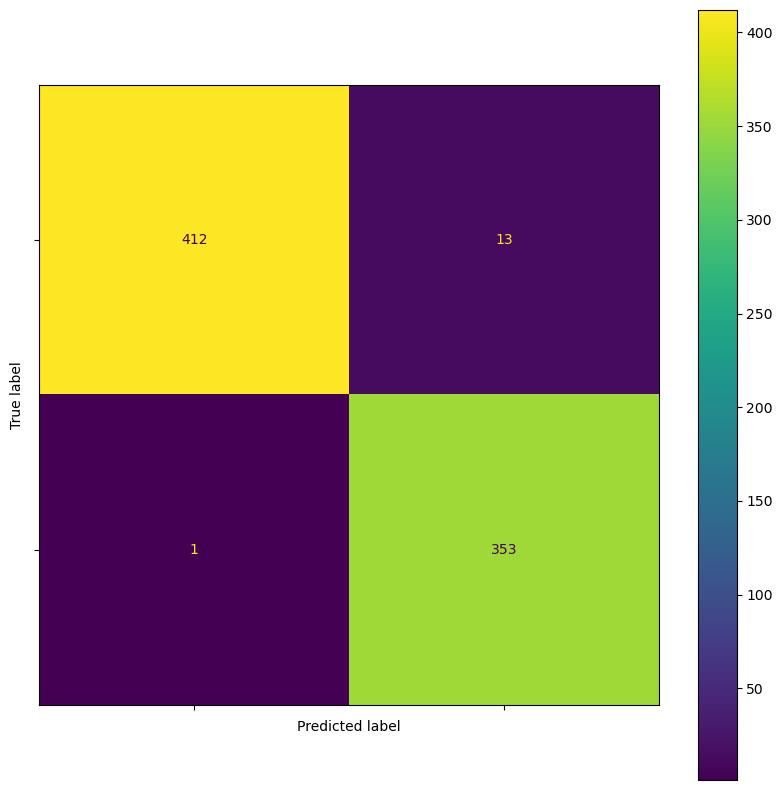

In [25]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [53]:
images_val = [] # stores actual image data
labels_val = [] # stores labels (as integer - because this is what our network needs)
label_names_val = [] # maps label ints to their actual categories so we can understand predictions later

SIZE1 = (64,64)
# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists

for filename in tqdm(os.listdir('hover-data-border-test')): # hover = 0
    # extract unique ID from file name
    #UID = filename.split('.')[0]
    img = cv2.imread(f'hover-data-border-test/{filename}')

    rzd = cv2.resize(img, SIZE1)
    # iterate over all hands annotated in the image
    # get the annotated hand's label
    # if we have not seen this label yet, add it to the list of labels
    #label = annotation['labels'][i]

    images_val.append(rzd)
    labels_val.append(0)

for filename in tqdm(os.listdir('touch-data-border-test')): # hover = 0
    # extract unique ID from file name
    #UID = filename.split('.')[0]
    img = cv2.imread(f'touch-data-border-test/{filename}')

    # iterate over all hands annotated in the image
    # get the annotated hand's label
    # if we have not seen this label yet, add it to the list of labels
    #label = annotation['labels'][i]
    
    rzd = cv2.resize(img, SIZE1)

    images_val.append(rzd)
    labels_val.append(1)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [54]:
X_test_val = np.array(images_val).astype('float32')
X_test_val = X_test_val / 255.

#y_train_one_hot_v = to_categorical(y_train)
y_test_one_hot_v = to_categorical(labels_val)

test_label_v = y_test_one_hot_v

2/2 [==============================] - 0s 5ms/step
before [[2.0206885e-01 7.9793113e-01]
 [2.0693009e-01 7.9306990e-01]
 [4.8263395e-01 5.1736605e-01]
 [2.6203334e-01 7.3796666e-01]
 [2.4346308e-01 7.5653696e-01]
 [6.0091650e-01 3.9908350e-01]
 [3.4909543e-01 6.5090454e-01]
 [4.2067394e-01 5.7932597e-01]
 [5.7839322e-01 4.2160678e-01]
 [4.1409272e-01 5.8590728e-01]
 [9.1289473e-01 8.7105304e-02]
 [4.4049129e-01 5.5950862e-01]
 [9.2108858e-01 7.8911357e-02]
 [4.5079386e-01 5.4920608e-01]
 [9.9484491e-01 5.1550725e-03]
 [4.2439818e-01 5.7560182e-01]
 [9.3503881e-01 6.4961247e-02]
 [1.9675300e-01 8.0324697e-01]
 [9.7122610e-01 2.8773883e-02]
 [5.2754718e-01 4.7245288e-01]
 [4.4798416e-01 5.5201584e-01]
 [5.7122993e-01 4.2877010e-01]
 [8.8970947e-01 1.1029056e-01]
 [2.1091123e-01 7.8908879e-01]
 [3.6222806e-11 1.0000000e+00]
 [1.7176262e-11 1.0000000e+00]
 [7.2516569e-11 1.0000000e+00]
 [5.2984400e-10 1.0000000e+00]
 [3.7244409e-11 1.0000000e+00]
 [4.5833781e-11 1.0000000e+00]
 [2.7724083e

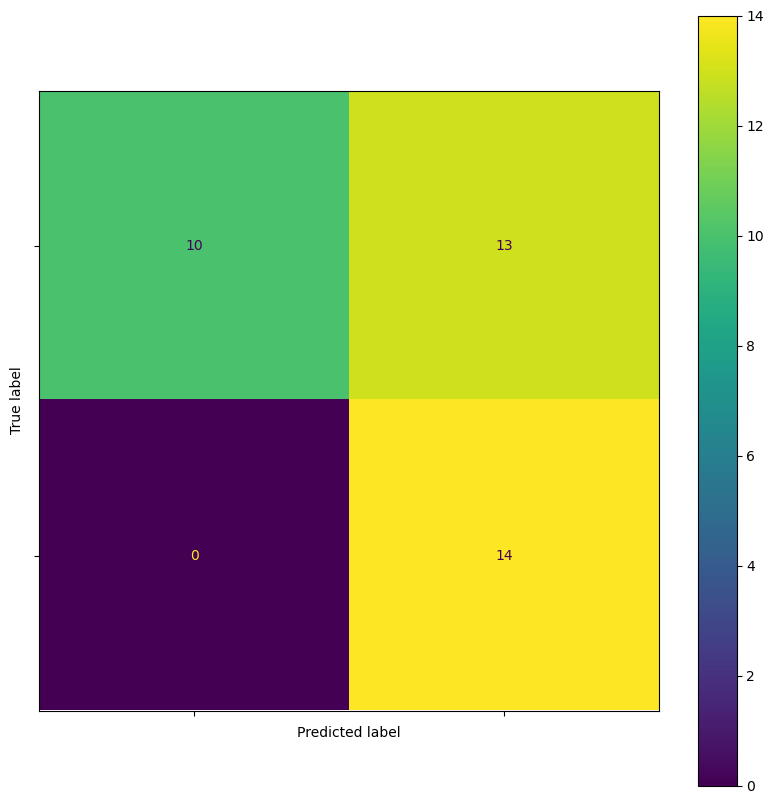

In [31]:
# let the model make predictions for our training data
y_predictions_val = model.predict(X_test_val)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions_val)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions_val = np.argmax(y_predictions_val, axis=1)

print('probabilities', y_predictions_val)

# create and plot confusion matrix
conf_matrix = confusion_matrix(labels_val, y_predictions_val)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [56]:
model_erwin = keras.models.load_model("erwin_final")

2/2 [==============================] - 0s 8ms/step
before [[4.3029079e-01 5.6970918e-01]
 [7.1316296e-01 2.8683707e-01]
 [9.1767788e-01 8.2322150e-02]
 [8.2425159e-01 1.7574841e-01]
 [9.2399544e-01 7.6004609e-02]
 [9.9414515e-01 5.8547962e-03]
 [9.6262968e-01 3.7370306e-02]
 [2.0892605e-01 7.9107392e-01]
 [3.6419010e-01 6.3580990e-01]
 [4.5099437e-02 9.5490062e-01]
 [9.8791611e-01 1.2083947e-02]
 [1.9576016e-01 8.0423981e-01]
 [9.7860217e-01 2.1397892e-02]
 [1.0149876e-01 8.9850122e-01]
 [9.9698097e-01 3.0190214e-03]
 [5.3947769e-02 9.4605219e-01]
 [9.7652006e-01 2.3479909e-02]
 [2.8131935e-03 9.9718684e-01]
 [9.7581238e-01 2.4187621e-02]
 [5.2994591e-01 4.7005403e-01]
 [2.0214537e-01 7.9785466e-01]
 [9.0667278e-01 9.3327209e-02]
 [9.7382122e-01 2.6178747e-02]
 [6.9339454e-02 9.3066061e-01]
 [3.0304996e-13 1.0000000e+00]
 [3.8690069e-13 1.0000000e+00]
 [2.8198029e-11 1.0000000e+00]
 [5.5902194e-10 1.0000000e+00]
 [2.3914338e-11 1.0000000e+00]
 [2.4867212e-11 1.0000000e+00]
 [1.1734280e

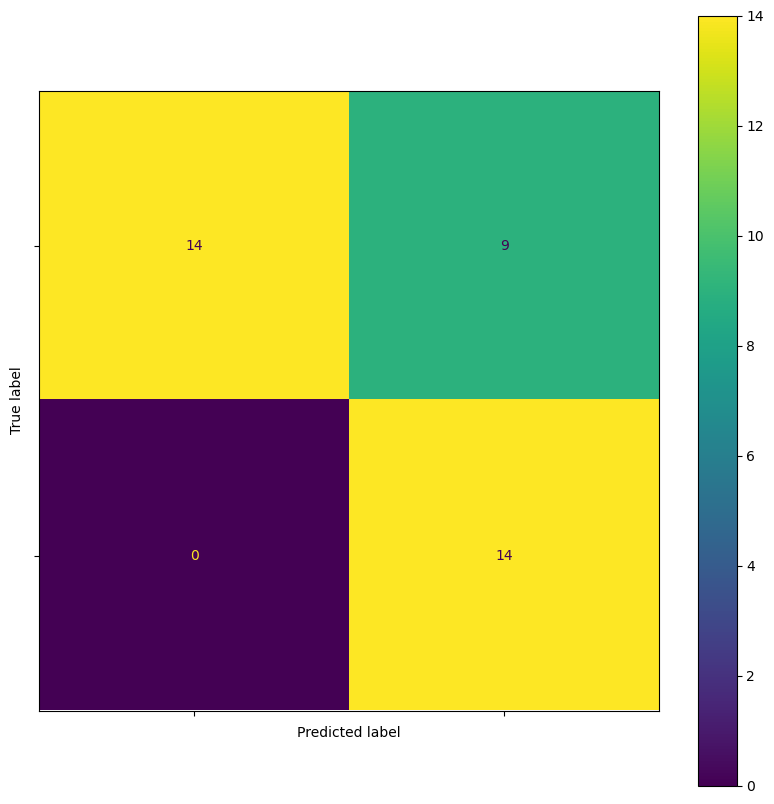

In [57]:
# let the model make predictions for our training data
y_predictions_val = model_erwin.predict(X_test_val)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions_val)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions_val = np.argmax(y_predictions_val, axis=1)

print('probabilities', y_predictions_val)

# create and plot confusion matrix
conf_matrix = confusion_matrix(labels_val, y_predictions_val)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

## let's test our model in action

In [68]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

1/1 [==============================] - 0s 277ms/step
stop 1.0


(9, 9, 3, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

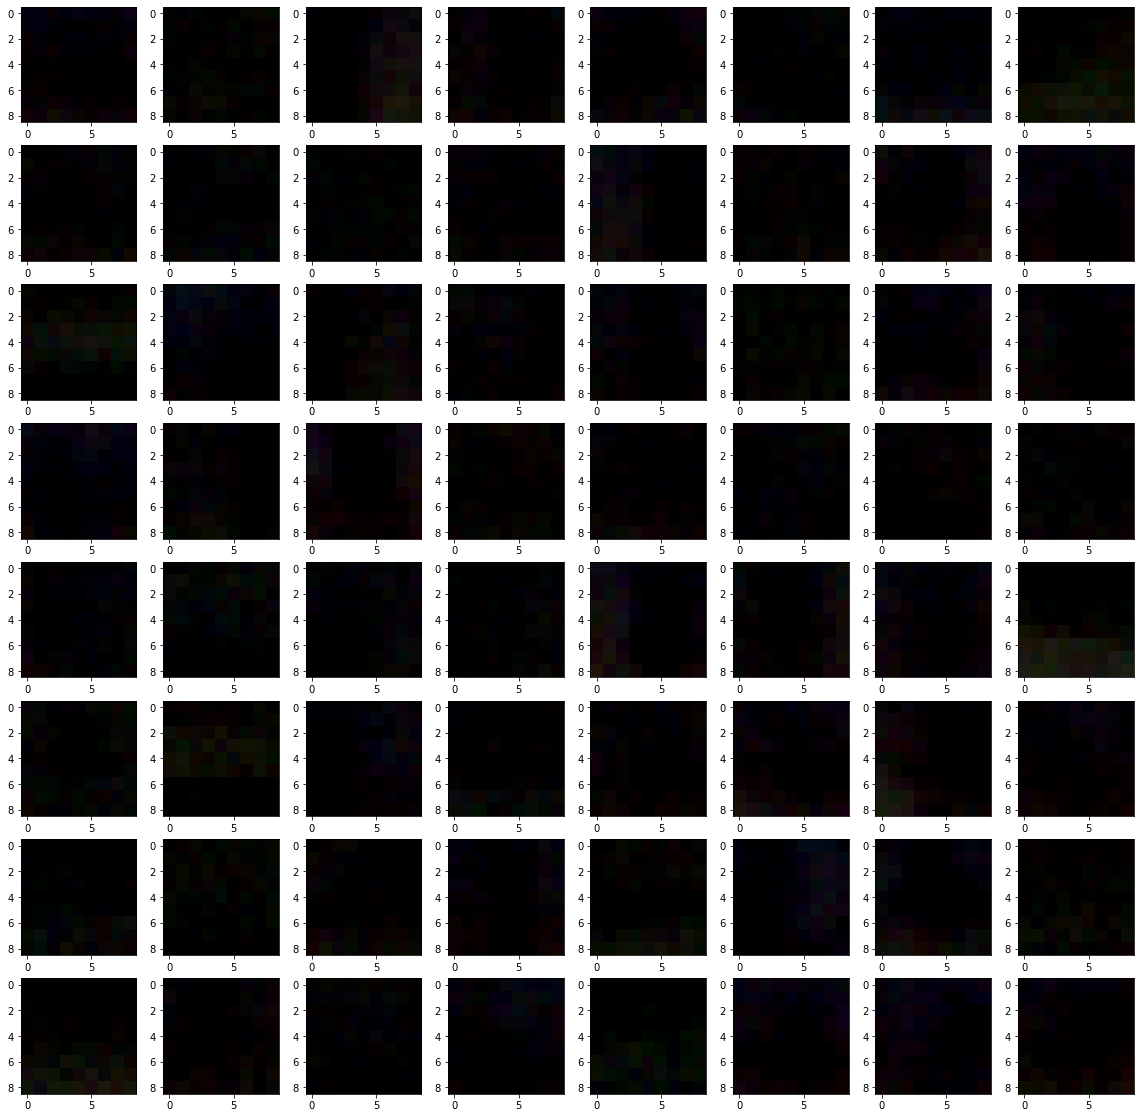

In [54]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j]
        axes[i][j].imshow(img)

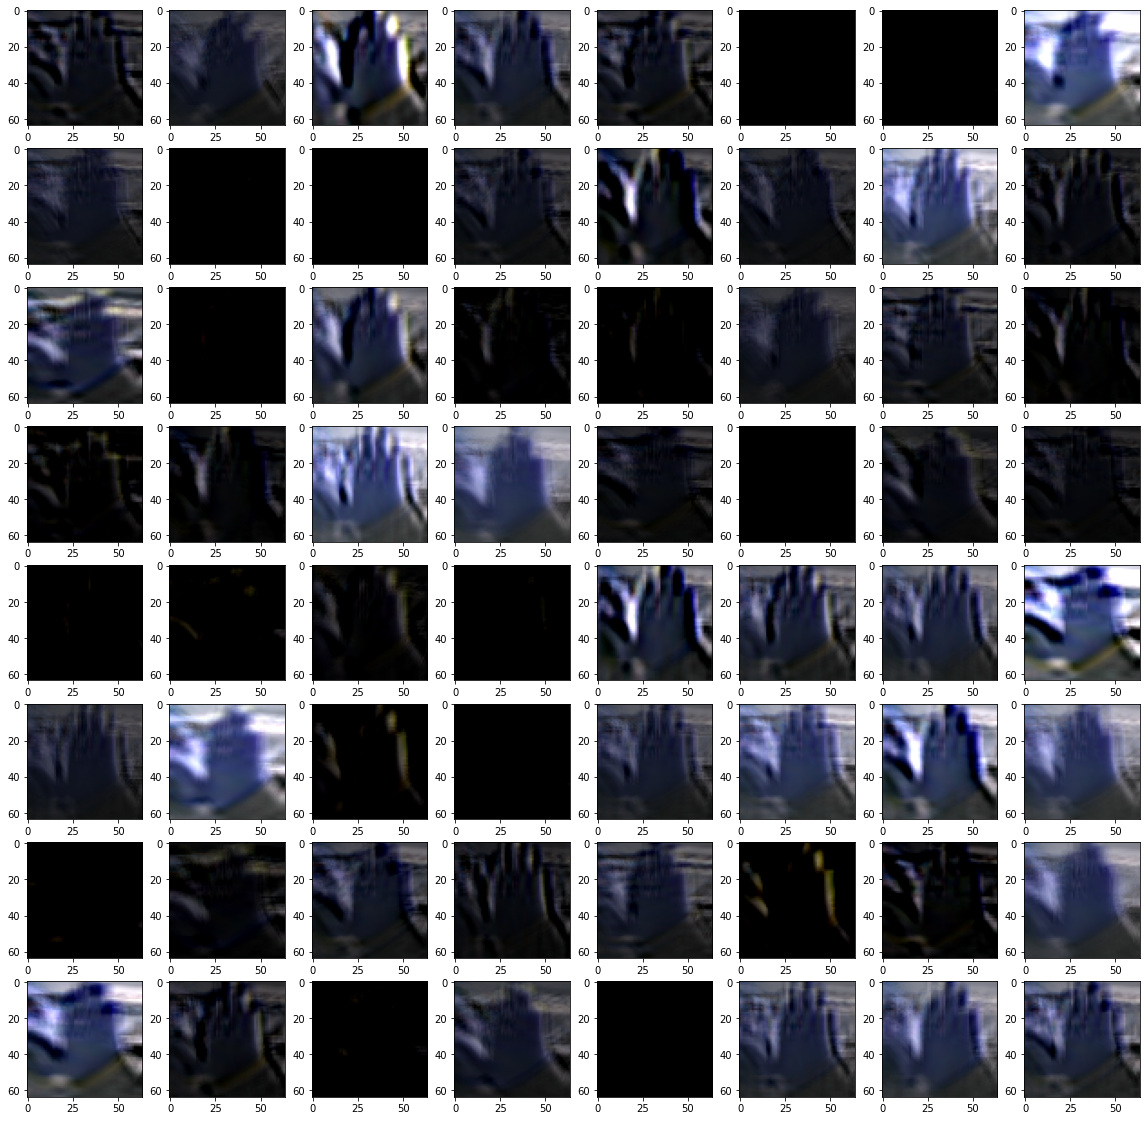

In [55]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        #gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        #filtered = cv2.filter2D(gray, -1, kernel)
        filtered = cv2.filter2D(resized, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [69]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best

# colorchannel = 3 -> deswegen von vorne nochmal trainieren upsidupsi
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass